In [ ]:
!nvidia-smi

Fri Dec 29 05:36:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install TensorFlow-GPU 2.0 and TensorRT Runtime

In [ ]:
!sudo apt-get update
!sudo apt-get install -y tensorrt

In [ ]:
# check TensorRT version
import tensorflow as tf
print("TensorFlow version: ", tf.version.VERSION)
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorFlow version:  2.15.0
TensorRT version: 
ii  libnvinfer-bin                            8.6.1.6-1+cuda12.0                      amd64        TensorRT binaries
ii  libnvinfer-dev                            8.6.1.6-1+cuda12.0                      amd64        TensorRT development libraries
ii  libnvinfer-dispatch-dev                   8.6.1.6-1+cuda12.0                      amd64        TensorRT development dispatch runtime libraries
ii  libnvinfer-dispatch8                      8.6.1.6-1+cuda12.0                      amd64        TensorRT dispatch runtime library
ii  libnvinfer-headers-dev                    8.6.1.6-1+cuda12.0                      amd64        TensorRT development headers
ii  libnvinfer-headers-plugin-dev             8.6.1.6-1+cuda12.0                      amd64        TensorRT plugin headers
ii  libnvinfer-lean-dev                       8.6.1.6-1+cuda12.0                      amd64        TensorRT lean runtime libraries
ii  libnvinfer-lean8                        

### Importing required libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

## Load the Data and Pre-trained Model

### Data

In [ ]:
!mkdir ./data
!wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
!wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
!wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
!wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

### Model

Thoughout this project, we will be using InceptionV3. Here we import the model from Keras.

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


When we benchmark our optimized TF-TRT models, they will be saved TensorFlow (not Keras) models. In order to have a fair comparison, here we save our Keras model as a TensorFlow model

In [ ]:
# Save the entire model as a TensorFlow SavedModel.
tf.saved_model.save(model, 'inceptionv3_saved_model')

##Create Batched Input

In [ ]:
def batch_input(batch_size=8):
  batched_input = np.zeros((batch_size, 299, 299, 3), dtype=np.float32)

  for i in range(batch_size):
    img_path = './data/img%d.JPG' % (i % 4)
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    batched_input[i, :] = x

  batched_input = tf.constant(batched_input)
  return batched_input

In [ ]:
batched_input = batch_input(batch_size=32)

## Load TensorFlow SavedModel

In [ ]:
def load_tf_saved_model(input_saved_model_dir):
    print(f'Loading saved model {input_saved_model_dir}...')
    saved_model_loaded = tf.saved_model.load(input_saved_model_dir, tags=[tag_constants.SERVING])
    return saved_model_loaded

load a previously saved InceptionV3 model.

## Baseline for Prediction Throughput and Accuracy

### Naive Inference with TensorFlow 2

The following will serve as a baseline for prediction throughput and accuracy. Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [ ]:
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0]

  for i in range(N_warmup_run):
    labeling = infer(batched_input)
    preds = labeling['predictions'].numpy()

  for i in range(N_run):
    start_time = time.time()

    labeling = infer(batched_input)

    preds = labeling['predictions'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)

    all_preds.append(preds)

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
  return all_preds

### Observe Accuracy


In [ ]:
def show_predictions(model):

  img_path = './data/img0.JPG'  # golden_retriever
  img = image.load_img(img_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = tf.constant(x)

  labeling = model(x)
  preds = labeling['predictions'].numpy()

  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
  plt.subplot(2,2,1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])

#Convert a TensorFlow saved model into a TF-TRT Graph

Convert a TensorFlow saved model into a TF-TRT optimized graph . We will use the optimized graph to make predictions and will benchmark its performance.

In [ ]:
def convert_to_trt_graph_and_save(precision_mode='float32',
                                  input_saved_model_dir='inceptionv3_saved_model',
                                  calibration_data=batched_input):

    if precision_mode == 'float32':
        precision_mode = trt.TrtPrecisionMode.FP32
        converted_save_suffix = '_TFTRT_FP32'

    if precision_mode == 'float16':
        precision_mode = trt.TrtPrecisionMode.FP16
        converted_save_suffix = '_TFTRT_FP16'

    if precision_mode == 'int8':
        precision_mode = trt.TrtPrecisionMode.INT8
        converted_save_suffix = '_TFTRT_INT8'

    output_saved_model_dir = input_saved_model_dir + converted_save_suffix

    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
        precision_mode=precision_mode,
        max_workspace_size_bytes=8000000000
    )

    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_saved_model_dir,
        conversion_params=conversion_params
    )

    print('Converting {} to TF-TRT graph precision mode {}...'.format(input_saved_model_dir, precision_mode))

    if precision_mode == trt.TrtPrecisionMode.INT8:
      def calibration_input_fn():
        yield (calibration_data, )
      converter.convert(calibration_input_fn=calibration_input_fn)

    else:
        converter.convert()

    print('Saving converted model to {}...'.format(output_saved_model_dir))
    converter.save(output_saved_model_dir=output_saved_model_dir)
    print('Complete')

In [ ]:
convert_to_trt_graph_and_save(precision_mode='int8', input_saved_model_dir='inceptionv3_saved_model')  # mode = float32 or float16 for convertion in Float 32 or Float 16 respectively.

Converting inceptionv3_saved_model to TF-TRT graph precision mode INT8...
Saving converted model to inceptionv3_saved_model_TFTRT_INT8...
Complete


In [ ]:
!saved_model_cli show --all --dir inceptionv3_saved_model_TFTRT_INT8

2023-12-29 05:46:36.946451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 05:46:36.946514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 05:46:36.948372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
       

## Benchmark TF-TRT INT8

Load the optimized TF model.

In [ ]:
saved_model_loaded = load_tf_saved_model('inceptionv3_saved_model_TFTRT_INT8')

Loading saved model inceptionv3_saved_model_TFTRT_INT8...


In [ ]:
infer = saved_model_loaded.signatures['serving_default']

Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [ ]:
all_preds = predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000)

Steps 0-50 average: 17.1ms
Steps 50-100 average: 16.6ms
Steps 100-150 average: 18.5ms
Steps 150-200 average: 19.2ms
Steps 200-250 average: 19.2ms
Steps 250-300 average: 18.7ms
Steps 300-350 average: 16.9ms
Steps 350-400 average: 16.7ms
Steps 400-450 average: 16.6ms
Steps 450-500 average: 16.8ms
Steps 500-550 average: 16.8ms
Steps 550-600 average: 16.8ms
Steps 600-650 average: 16.9ms
Steps 650-700 average: 16.8ms
Steps 700-750 average: 16.8ms
Steps 750-800 average: 16.9ms
Steps 800-850 average: 17.0ms
Steps 850-900 average: 17.8ms
Steps 900-950 average: 20.1ms
Steps 950-1000 average: 19.6ms
Throughput: 1806 images/s


35363/35363 [==============================] - 0s 0us/step
./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.7439516), ('n02099712', 'Labrador_retriever', 0.112759486), ('n02104029', 'kuvasz', 0.017359912)]


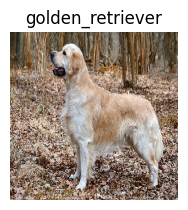

In [ ]:
show_predictions(infer)